# Exploration 10. Translator
---
# (프로젝트) 단어 Level로 번역기 업그레이드하기

## [루브릭]
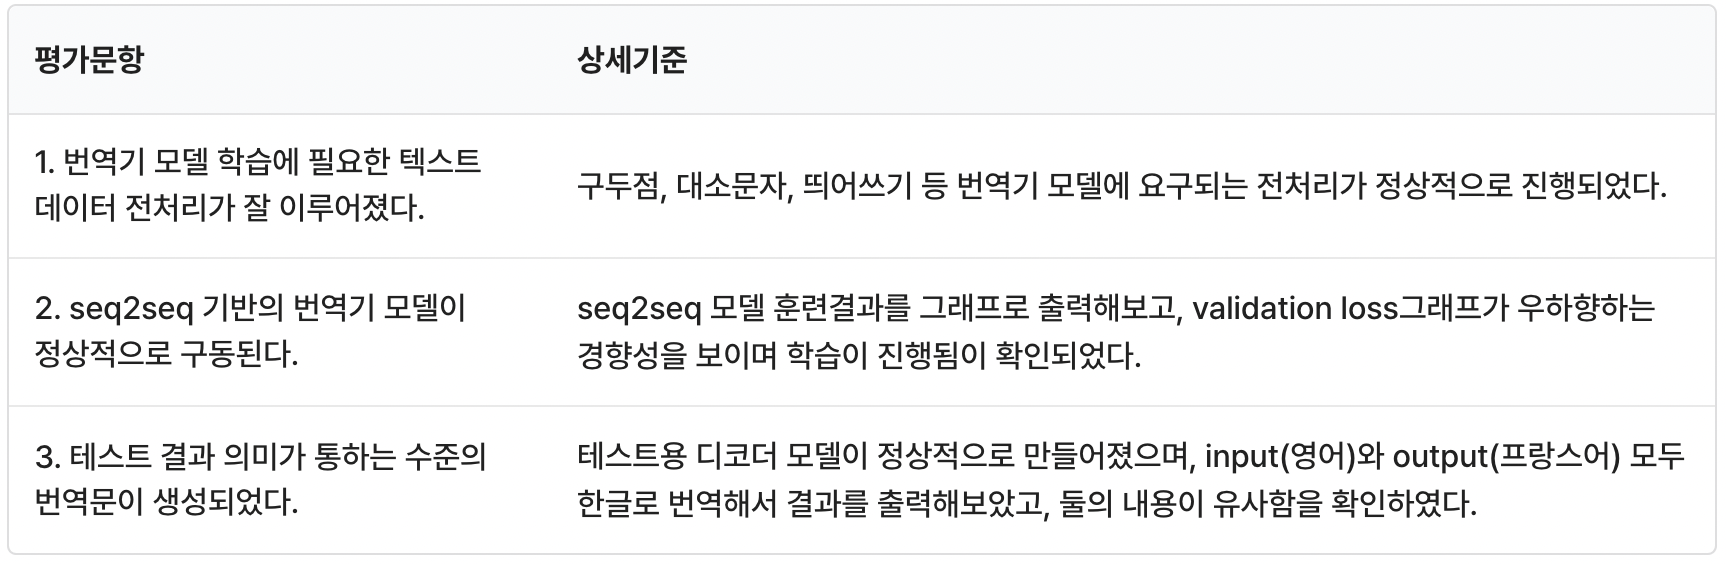

## Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)

In [165]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model
import numpy as np

In [166]:
import os
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 197463


,eng,fra,cc
147883,The notebook is not yours. It's his.,"Le cahier n'est pas à toi, c'est le sien.",CC-BY 2.0 (France) Attribution: tatoeba.org #5...
161151,You seem to know everything about this.,Vous semblez tout savoir là-dessus.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
21289,Tom tickled Mary.,Tom chatouillait Marie.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
67988,We need some more water.,Il nous faut davantage d'eau.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
18419,I am not kidding.,Je ne blague pas.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...


In [167]:
lines = lines[['eng', 'fra']][:33000] # 3만 3천 샘플 사용
lines.sample(5)

,eng,fra
944,Forget it.,Oubliez ça !
27163,We rarely eat out.,Nous mangeons rarement dehors.
21092,Tom is merciless.,Tom est impitoyable.
8700,They're spies.,Ce sont des espions.
12575,We're finished.,Nous avons fini.


구두점(Punctuation)을 단어와 분리하고, 소문자로 변환 후 띄어쓰기 단위로 토큰화를 수행하겠습니다.   

In [168]:
import re

In [169]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r'([?.!,])', r' \1 ', sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r'[^a-zA-ZÀ-Ÿ-.?!,\']+', ' ', sentence)
    sentence = sentence.strip()
    return sentence

In [170]:
corpus_eng = []
for sentence in lines.eng:
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus_eng.append(preprocessed_sentence)

In [171]:
corpus_fra = []
for sentence in lines.fra:
    preprocessed_sentence = preprocess_sentence(sentence)
    preprocessed_sentence = "<sos> " + preprocessed_sentence + " <eos>"
    corpus_fra.append(preprocessed_sentence)

In [172]:
corpus_eng[:10] , corpus_fra[:10]

(['go .',
  'go .',
  'go .',
  'go .',
  'hi .',
  'hi .',
  'run !',
  'run !',
  'run !',
  'run !'],
 ['<sos> va ! <eos>',
  '<sos> marche . <eos>',
  '<sos> en route ! <eos>',
  '<sos> bouge ! <eos>',
  '<sos> salut ! <eos>',
  '<sos> salut . <eos>',
  '<sos> cours ! <eos>',
  '<sos> courez ! <eos>',
  '<sos> prenez vos jambes à vos cous ! <eos>',
  '<sos> file ! <eos>'])

## Step 2. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.

In [173]:
eng_tokenizer = Tokenizer(char_level=False)   # Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(corpus_eng)               # eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(corpus_eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:10]

[[22], [22], [22], [22], [778], [778], [203], [203], [203], [203]]

In [174]:
fra_tokenizer = Tokenizer(char_level=False)   # 문자 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(corpus_fra)                 # fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(corpus_fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:10]

[[1, 59, 2],
 [1, 346, 2],
 [1, 22, 505, 2],
 [1, 714, 2],
 [1, 745, 2],
 [1, 745, 2],
 [1, 654, 2],
 [1, 1906, 2],
 [1, 173, 253, 1036, 20, 253, 2773, 2],
 [1, 1478, 2]]

In [175]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4765
프랑스어 단어장의 크기 : 9083


In [176]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 6
프랑스어 시퀀스의 최대 길이 14


In [177]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4765
프랑스어 단어장의 크기 : 9083
영어 시퀀스의 최대 길이 6
프랑스어 시퀀스의 최대 길이 14


In [178]:
sos_token = 'sos'
eos_token = 'eos'

In [179]:
fra_tokenizer.word_index

{'sos': 1,
 'eos': 2,
 'je': 3,
 'tom': 4,
 'est': 5,
 'vous': 6,
 'pas': 7,
 'il': 8,
 'le': 9,
 'de': 10,
 'nous': 11,
 'ne': 12,
 'suis': 13,
 'tu': 14,
 "c'est": 15,
 'la': 16,
 'a': 17,
 "j'ai": 18,
 'un': 19,
 'à': 20,
 'ce': 21,
 'en': 22,
 'me': 23,
 'ça': 24,
 'êtes': 25,
 'que': 26,
 'les': 27,
 'une': 28,
 'moi': 29,
 'es': 30,
 'elle': 31,
 'sont': 32,
 'ils': 33,
 'sommes': 34,
 'fait': 35,
 'tout': 36,
 'elles': 37,
 'qui': 38,
 "n'est": 39,
 'des': 40,
 'mon': 41,
 'toi': 42,
 'te': 43,
 'bien': 44,
 'y': 45,
 'ai': 46,
 'était': 47,
 'très': 48,
 'ici': 49,
 'été': 50,
 'se': 51,
 'du': 52,
 'besoin': 53,
 'faire': 54,
 "l'air": 55,
 'peux': 56,
 'cela': 57,
 'personne': 58,
 'va': 59,
 'veux': 60,
 'votre': 61,
 'as': 62,
 'fais': 63,
 "j'aime": 64,
 'on': 65,
 "s'est": 66,
 'là': 67,
 'ton': 68,
 'avez': 69,
 'avons': 70,
 'faut': 71,
 'comment': 72,
 'tous': 73,
 'ont': 74,
 'ma': 75,
 'trop': 76,
 'aller': 77,
 'monde': 78,
 "c'était": 79,
 'au': 80,
 'maintenant': 

In [180]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [181]:
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 59], [1, 346], [1, 22, 505]]
[[59, 2], [346, 2], [22, 505, 2]]


In [182]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 6)
프랑스어 입력데이터의 크기(shape) : (33000, 14)
프랑스어 출력데이터의 크기(shape) : (33000, 14)


In [183]:
print(encoder_input[0])

[22  0  0  0  0  0]


## Step 4. 임베딩 층(Embedding layer) 사용하기


In [184]:
embedding_size = 512
hidden_size = 512

In [185]:
from tensorflow.keras.layers import Input, Embedding, Masking
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

# 인코더에서 사용할 임베딩
encoder_inputs = Input(shape=(None,), name='encoder_input')
enc_emb =  Embedding(eng_vocab_size, embedding_size)(encoder_inputs)
encoder_lstm = LSTM(hidden_size, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

In [186]:
# 디코더에서 사용할 임베딩
decoder_inputs = Input(shape=(None,), name='decoder_input')
dec_emb =  Embedding(fra_vocab_size, embedding_size)(decoder_inputs)
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = encoder_states)

In [187]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [188]:
# train, test data 분리
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input_train))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_train))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_train))

영어 학습데이터의 크기(shape) : (30000, 6)
프랑스어 학습 입력데이터의 크기(shape) : (30000, 14)
프랑스어 학습 출력데이터의 크기(shape) : (30000, 14)


In [189]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

## Step 5. 모델 구현하기


In [190]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [191]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [192]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, None, 512)    2439680     encoder_input[0][0]              
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, None, 512)    4650496     decoder_input[0][0]              
___________________________________________________________________________________________

In [193]:
history = model.fit(x=[encoder_input_train, decoder_input_train],
         y = decoder_target_train,
         validation_data = ([encoder_input_test, decoder_input_test],
                           decoder_target_test),
         batch_size=128,
         epochs=30)

Epoch 1/30
235/235 [==============================] - 11s 36ms/step - loss: 1.7961 - val_loss: 1.4423
Epoch 2/30
235/235 [==============================] - 8s 34ms/step - loss: 1.2798 - val_loss: 1.2073
Epoch 3/30
235/235 [==============================] - 8s 35ms/step - loss: 1.0944 - val_loss: 1.1028
Epoch 4/30
235/235 [==============================] - 8s 35ms/step - loss: 0.9731 - val_loss: 1.0095
Epoch 5/30
235/235 [==============================] - 9s 36ms/step - loss: 0.8782 - val_loss: 0.9521
Epoch 6/30
235/235 [==============================] - 9s 37ms/step - loss: 0.7981 - val_loss: 0.9008
Epoch 7/30
235/235 [==============================] - 9s 37ms/step - loss: 0.7278 - val_loss: 0.8619
Epoch 8/30
235/235 [==============================] - 9s 37ms/step - loss: 0.6663 - val_loss: 0.8335
Epoch 9/30
235/235 [==============================] - 9s 37ms/step - loss: 0.6129 - val_loss: 0.8058
Epoch 10/30
235/235 [==============================] - 9s 38ms/step - loss: 0.5657 - val_l

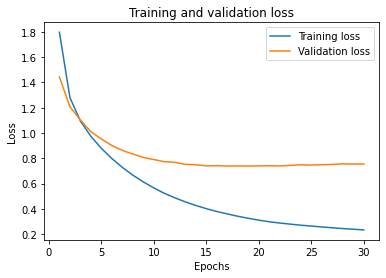

In [194]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, label='Validation loss') # b는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Step 6. 모델 평가하기


epoch 10 이전에 수렴을 한 것으로 보입니다. 신규 데이터로 결과를 확인해 보도록 하겠습니다. 

In [195]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, None)]            0         
_________________________________________________________________
embedding_15 (Embedding)     (None, None, 512)         2439680   
_________________________________________________________________
lstm_10 (LSTM)               [(None, 512), (None, 512) 2099200   
Total params: 4,538,880
Trainable params: 4,538,880
Non-trainable params: 0
_________________________________________________________________


In [196]:
decoder_state_input_h = Input(shape=(embedding_size,))
decoder_state_input_c = Input(shape=(embedding_size,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = Embedding(fra_vocab_size, embedding_size)(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)

decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs2] + decoder_states2)
decoder_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, None, 512)    4650496     decoder_input[0][0]              
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 512)]        0                                            
___________________________________________________________________________________________

In [197]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # 타겟 시작점에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = fra2idx['sos']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_word

        # 에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_word == '' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [198]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp = ''
    for i in input_seq:
        if (i!=0):
            temp = temp + idx2eng[i]+' '
    return temp

In [199]:
# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0): 
            temp = temp + idx2fra[i] + ' '
    return temp

In [200]:
test_lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
test_lines = test_lines[['eng', 'fra']][33000:]
test_lines.sample(5)

,eng,fra
77292,Can you move closer to me?,Peux-tu te rapprocher de moi ?
34953,Everyone's watching.,Tout le monde regarde.
180428,Could you recommend a nice restaurant near here?,Peux-tu recommander un chouette restaurant prè...
74837,They eat fish on Fridays.,Ils mangent du poisson les vendredis.
165043,He had the ambition to be prime minister.,Il nourrissait l'ambition de devenir premier m...


In [201]:
corpus_eng_test = []
for sentence in test_lines.eng:
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus_eng_test.append(preprocessed_sentence)

In [202]:
corpus_fra_test = []
for sentence in test_lines.fra:
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus_fra_test.append(preprocessed_sentence)

In [203]:
len(corpus_eng_test)

164463

In [204]:
corpus_eng_test[:5]

['we argued politics .',
 'we ate some apples .',
 'we better be going .',
 'we better be going .',
 'we can do that now .']

In [205]:
corpus_fra_test[:5]

['nous avons discuté politique .',
 'nous mangeâmes quelques pommes .',
 "nous ferions mieux d'y aller .",
 "on ferait mieux d'y aller .",
 'on peut le faire maintenant .']

In [206]:
test_input_text = eng_tokenizer.texts_to_sequences(corpus_eng_test)    # 단어를 숫자값 인덱스로 변환하여 저장

In [207]:
test_input_text[:10]

[[17, 3701],
 [17, 333, 154, 1023],
 [17, 207, 27, 129],
 [17, 207, 27, 129],
 [17, 30, 18, 16, 58],
 [17, 30, 310, 16],
 [17, 30, 310, 16],
 [17, 30, 310, 16],
 [17, 30, 310, 16],
 [17, 30, 310, 16]]

In [208]:
# 신규 문장을 불러 온 뒤 테스트
for seq_index in [1,201,501,1004,2015]:
    input_seq = test_input_text[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', corpus_eng_test[seq_index])
    print('정답 문장:', corpus_fra_test[seq_index])
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1])

-----------------------------------
입력 문장: we ate some apples .
정답 문장: nous mangeâmes quelques pommes .
번역기가 번역한 문장:  nous de des de
-----------------------------------
입력 문장: we're enthusiastic .
정답 문장: nous sommes enthousiastes .
번역기가 번역한 문장:  eos eos eos eo
-----------------------------------
입력 문장: where is everybody ?
정답 문장: où est tout le monde ?
번역기가 번역한 문장:  eos les les eo
-----------------------------------
입력 문장: you're a weird kid .
정답 문장: t'es un gamin bizarre .
번역기가 번역한 문장:  vous vous ton eo
-----------------------------------
입력 문장: give me my pen back .
정답 문장: rends-moi mon stylo .
번역기가 번역한 문장:  donne mon mon eo


In [209]:
# 기존 학습 문장내 테스트
for seq_index in [1,201,501,1004,2015]:
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', seq2src(encoder_input_test[seq_index]))
    print('정답 문장:', seq2tar(decoder_input_test[seq_index]))
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1])

-----------------------------------
입력 문장: mosquitos love me 
정답 문장: sos les moustiques raffolent de moi 
번역기가 번역한 문장:  ceux eos bien eo
-----------------------------------
입력 문장: relax 
정답 문장: sos détends toi 
번역기가 번역한 문장:  eos eos eos eo
-----------------------------------
입력 문장: i need it today 
정답 문장: sos j'en ai besoin aujourd'hui 
번역기가 번역한 문장:  il besoin besoi
-----------------------------------
입력 문장: it's no use 
정답 문장: sos ça ne sert à rien 
번역기가 번역한 문장:  problème ne n'
-----------------------------------
입력 문장: you look awesome 
정답 문장: sos vous êtes magnifique 
번역기가 번역한 문장:  vous vous vou


## 회고 
- sos_token과 eos_token을 각각 '<sos>', '<eos>'로 만들었는데 tokenizer를 수행한 결과 화살괄호(< >)는 사라지고 문자만 tokenizing이 되었습니다. 어떤 이유로 괄호는 사라지는지 추가로 확인이 필요할 것 같습니다. 
- (추가 확인 필요) Tokenizer는 인스턴스를 새로 생성할 때마다 word_index가 바뀌는 것인지 확인이 필요할 것 같습니다.  (동일한 training data로 반복적으로 만들더라도)
- 불어에 대한 이해는 낮지만 결과치를 보면 번역이 원활히 되지는 못한 것 같습니다. 추가적인 개선 방법에 대해 탐구가 필요할 것 같습니다. 
    
    
[참고]  
- https://github.com/PEBpung/Aiffel/blob/master/Project/Exploration/E15.%20%EB%8B%A8%EC%96%B4%20Level%EB%A1%9C%20seq2seq%20%EB%B2%88%EC%97%AD%EA%B8%B0%20%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb